# CS 136 day08: Probabilistic Linear Regression

## Outline

* **Part 1: Understanding the probabilistic model of linear regression**

* Exercise 1a: Compute feature transformation
* Exercise 1b-1c: Compute the parameters of the posterior
* Exercise 1d: Visualize samples from weight posterior as more data is observed
* Exercise 1e: Visualize samples of implied linear prediction function as more data is observed
* Exercise 1f: Compare to ML point estimation

## Takeaways

* Probabilistic view helps especially when we have few training examples
* Given enough data, the posterior will concentrate in weight space at the ML point estimate
* Hyperparameters like $\alpha$ (prior precision) and $\beta$ (likelihood precision) can matter

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats

In [ ]:
np.set_printoptions(precision=3, suppress=False)

In [ ]:
pd.options.display.float_format = '{:,.3g}'.format  # show 3 digits of precision

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Part 1: Probabilistic Model view of linear regression

### Task: Linear regression

Given $N$ observations of *paired* feature-outcome observations: $\{ x_n, t_n \}$. 

For now, we will assume:

* Input feature $x_n \in \mathbb{R}$ is a scalar
* Outcome value $t_n \in \mathbb{R}$ is a scalar

We're also given a feature transform function $\phi$, known in advance. 

For now, we'll assume that the "feature transform" $\phi(x_n)$ just simply passes along the features $x_n$, while adding an additional offset or "intercept" feature that is always 1. This is a *simplifying* assumption for today.

$$
\phi(x_n) = [ x_n, 1]
$$

We want to make good predictions of new outcomes $t_*$ given new features $x_*$.

After today, we can consider even more flexible input spaces and feature transforms

* $x_n$ may be a vector in some $F$-dimensional space
* $\phi$ can map each $x_n$ to a vector in $M$-dimensional space

We assume $F=1$ and $M=2$ to make visualization and basic understanding easy for today.


In [ ]:
def calc_features(x_N1, M=2):
    ''' Transform raw features into complete features useful for prediction
    
    Could do any non-linear transformations thought relevant for the problem.
    Here we'll just do an identity transform with an extra intercept feature.
    
    Args
    ----
    x_N1 : 2D array, shape (N, 1) = (n_examples,)
    
    Returns
    -------
    phi_NM : 2D array, shape (N, M) = (n_examples, n_transformed_features)
        First column will contain all ones (a bias or intercept feature)
        Second column will just include the raw features
    '''
    assert x_N1.ndim == 2
    assert x_N1.shape[1] == 1
    N = x_N1.shape[0]
    phi_NM = np.zeros((N, M))
    phi_NM[:,0] = 1
    phi_NM[:,1] = x_N1[:,0]
    return phi_NM

## Exercise 1a: Obtain transformed features $\phi(x_n)$ when $x_n = [2.0]$

In [ ]:
x_N1 = np.asarray([[2.0]])  # create a N=1 x F=1 array (one example, one feature)

# TODO call calc_features() to get the feature transform, yielding an (N, M) shaped array


## Define the  Prior

For now, we'll assume that weights come from a zero mean prior with some covariance scaled by $\alpha$:

$$
w \sim \mathcal{N}( 0, \alpha^{-1} I_M )
$$

## Define the Likelihood

Each observation (indexed by $n$) is drawn iid from a Normal (after conditioning on $w$):

$$
t_n | w \sim \mathcal{N}( t_n | w^T \phi(x_n), \beta^{-1} )
$$


### Parameter we'll treat as a random variable: $w$

* Weights vector: $w = [w_1, w_2, \ldots w_M]^T$, so $w \in \mathbb{R}^M$

### Parameters we'll treat as fixed: $\alpha$ and $\beta$


* Prior precision $\alpha > 0$

The larger $\alpha$ is, the more confident we are in the weight values before seeing any data.

* Likelihood precision $\beta > 0$

The larger $\beta$ is, the less the observed $t$ values vary from the predicted mean.

By definition, $\beta^{-1}$ defines the variance of our assumed Gaussian likelihood. So *precision* $\beta$ is an "inverse" variance.

## Create a simple toy data for analysis

In [ ]:
N = 2000  # Number of examples we observe
M = 2    # Number of transformed features

In [ ]:
# Create reproducible pseudorandom number generator
prng = np.random.RandomState(0)

Create the weight vector we'll use to generate our dataset

In [ ]:
true_w_M = np.asarray([1.2, -0.75])

Create a "true" alpha value which controls the prior precision

In [ ]:
true_alpha = 1.0

Create a "true" beta which defines the likelihood precision

In [ ]:
true_beta = 0.5

Create observed features $x$ and do a "feature transform" that just adds a column of all ones (an "intercept" feature)

In [ ]:
x_N1 = prng.uniform(low=-7, high=7, size=N)[:,np.newaxis]
phi_NM = calc_features(x_N1)

Generate outputs t using our assumed model

In [ ]:
t_N = prng.normal(np.matmul(phi_NM, true_w_M), 1.0/np.sqrt(true_beta))

In [ ]:
# Make backups of original data just in case
orig_x_N1 = x_N1.copy()
orig_phi_NM = phi_NM.copy()
orig_t_N = t_N.copy()

## Visualize the toy dataset

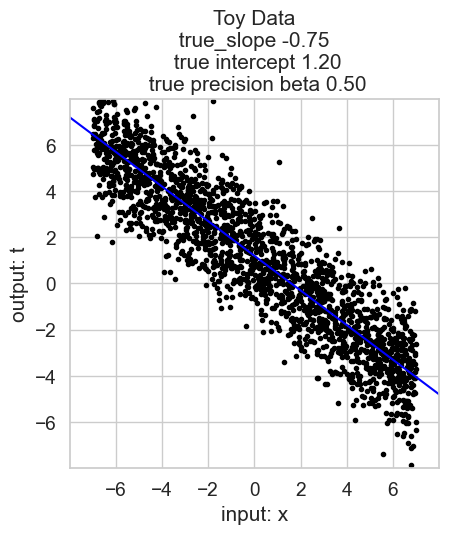

In [ ]:
plt.plot(orig_x_N1, orig_t_N, 'k.');

ax_h = plt.gca()
ax_h.set_aspect('equal', 'box');
ax_h.set_xlim([-8, 8]); ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
ax_h.set_ylim([-8, 8]); ax_h.set_yticks([-6, -4, -2, 0, 2, 4, 6]);

xgrid_G = np.linspace(-8, 8, 100)[:,np.newaxis]
plt.plot(xgrid_G, np.matmul(calc_features(xgrid_G), true_w_M), 'b-');

plt.xlabel('input: x');
plt.ylabel('output: t');
plt.title("Toy Data\n true_slope %.2f \n true intercept %.2f\n true precision beta %.2f" % (
    true_w_M[1], true_w_M[0], true_beta));

## Posterior over weights

Recall formulas for the posterior over the weight vector $w$, simplified for our zero-mean, diagonal-covariance prior on $w$:

\begin{align}
p( w | t) &= \text{MVNormPDF}( w | m, S )
\\
S^{-1} &= \alpha I_M + \beta \Phi^T \Phi
\\
m &= \beta S \Phi^T \mathbf{t}
\end{align}

In other words, the posterior is a Gaussian distribution, where:
* $m$ is the mean vector of shape $(M,)$ 
* $S$ is the covariance matrix of shape $(M, M)$


The ingredients of these formulas are:
* $\alpha > 0$ : prior precision
* $\beta > 0$ : likelihood precision
* $\Phi$ : N x M matrix of transformed features ("inputs")
* $\mathbf{t}$ : N-dimensional vector of observed outputs
* $I_M $: M x M [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix) (can create with `np.eye(M)`)

## Exercise 1b: Compute the parameters of the posterior

Translate the formulas above into concrete NumPy expressions that compute the mean $m$ and covariance $S$:m

In [ ]:
def calc_parameters_of_posterior(phi_NM, t_N, alpha=0.1, beta=0.1):
    ''' Compute parameters of the posterior for weights w
    
    Args
    ----
    phi_NM : 2D array, shape (N,M)
        Each row is a feature vector for one example
    t_N : 1D array, shape (N,)
        Each row is a output scalar value for one example
    alpha : positive scalar
        Prior precision
    beta : positive scalar
        Likelihood precision
    
    Returns
    -------
    m_M : posterior mean vector, shape (M,)
    S_MM : posterior covariance matrix, shape (M, M)
    '''
    N, M = phi_NM.shape
    invS_MM = np.eye(M) # TODO FIXME compute inverse of the posterior covariance S
    m_M = np.zeros(M)   # TODO FIXME compute posterior mean
    S_MM = np.eye(M)    # TODO FIXME use tools in np.linalg to invert invS_MM
    return m_M, S_MM

## Exercise 1c: Compute posterior parameters when given all N=2000 observations

How close is the posterior mean to the "true" vector of weights that generated the data?

How "uncertain" is the posterior (look at variance values in the covariance matrix)

In [ ]:
# TODO call calc_parameters_of_posterior(...) with the toy dataset we generated above, and the "true" alpha/beta values

In [ ]:
# TODO answer the questions above

## Exercise 1d: Visualize samples from weight posterior as more data is observed

Do you see the posterior "concentrate" its mass on the true value as more data is observed?

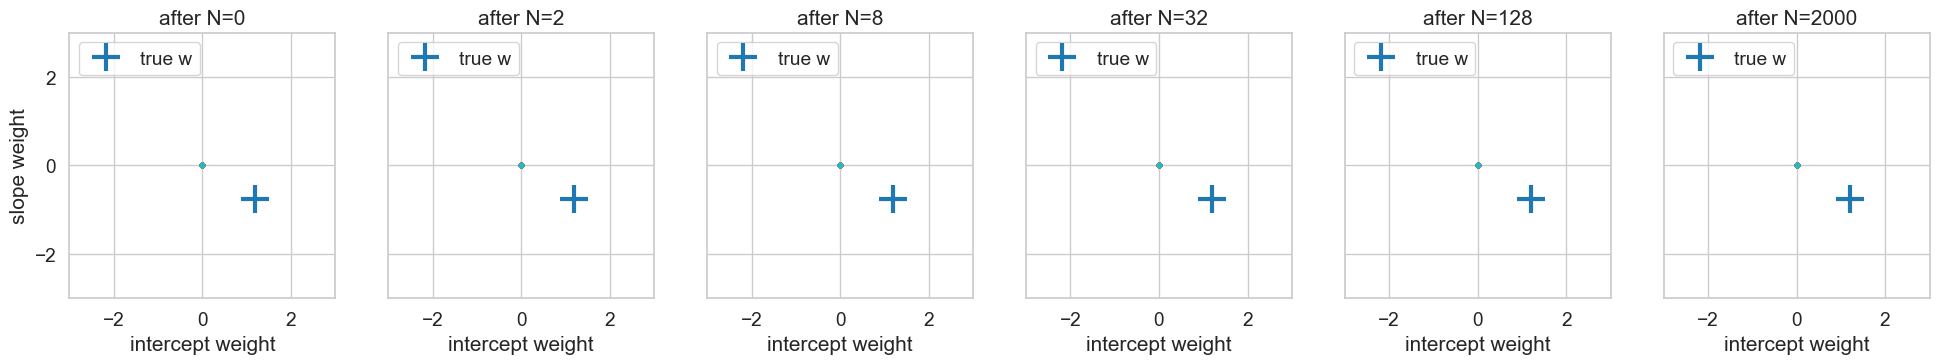

In [ ]:
# Define the number of observations to look at to make a posterior
N_values = [0, 2, 8, 32, 128, N]
C = len(N_values)

# Define the number of samples from the posterior to visualize
S = 100

# Create reproducible pseudorandom number generator
prng = np.random.RandomState(0)

# Create figure
fig_h, axgrid = plt.subplots(nrows=1, ncols=C, sharex=True, sharey=True, figsize=(C * 4, 4))

for col_id, Ncur in enumerate(N_values):

    # Create the posterior from the first Ncur observations
    # Hint: use phi_NM[:10] to get the first 10 observations
    m_M, S_MM = np.zeros(M), np.ones(M) # TODO FIXME call calc_parameters_of_posterior
    
    # Draw samples from the posterior with the parameters defined above
    w_SM = np.zeros((S, M)) # TODO FIXME call prng.multivariate_normal with correct params to get samples
        
    # Activate current subplot and get its handle
    ax_h = axgrid[col_id]
    for ss in range(S):
        ax_h.plot(w_SM[ss,0], w_SM[ss,1], '.')

    ax_h.plot(true_w_M[0], true_w_M[1], '+', markersize=20, mew=3, label='true w')
    ax_h.legend(loc='upper left');

    # Make plots pretty and standardized
    ax_h.set_aspect('equal', 'box');
    ax_h.set_xlim([-3, 3]); ax_h.set_xticks([-2, 0, 2]);
    ax_h.set_ylim([-3, 3]); ax_h.set_yticks([-2, 0, 2]);
    ax_h.set_xlabel('intercept weight')
    if col_id == 0:
        ax_h.set_ylabel('slope weight')
    ax_h.set_title('after N=%d' % Ncur)

## Exercise 1e: Visualize samples from posterior predictive as more data is observed

Does the predicted function look more and more appropriate for the observed data?

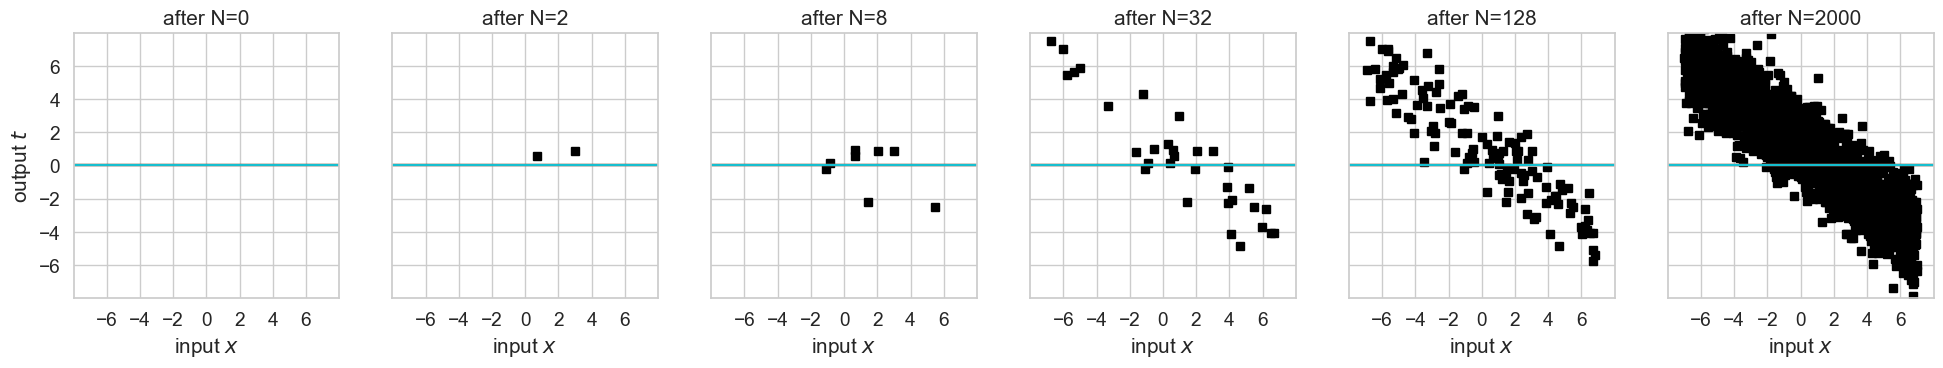

In [ ]:
# Define the number of observations to look at to make a posterior
N_values = [0, 2, 8, 32, 128, N]
C = len(N_values)

# Define the number of samples from the posterior to visualize
S = 10

# Create reproducible pseudorandom number generator
prng = np.random.RandomState(33)

# Create figure
fig_h, axgrid = plt.subplots(nrows=1, ncols=C, sharex=True, sharey=True, figsize=(C * 4, 4))

for col_id, Ncur in enumerate(N_values):

    # Create the posterior from the first Ncur observations
    # Hint: use phi_NM[:10] to get the first 10 observations
    m_M, S_MM = np.zeros(M), np.ones(M) # TODO FIXME call calc_parameters_of_posterior
    
    # Draw samples from the posterior with the parameters defined above
    w_SM = np.zeros((S, M)) # TODO FIXME call prng.multivariate_normal with correct params to get samples
    
    # Activate current subplot and get its handle
    ax_h = axgrid[col_id]
    
    # Show the observed data
    ax_h.plot(x_N1[:Ncur], t_N[:Ncur], linestyle='', marker='s', color='black')

    for ss in range(S):
        # Create a uniform grid of possible x values, to use in making predictions
        xgrid_G = np.linspace(-8, 8, 100)[:,np.newaxis]
        
        # Produce the output values *t* that we get from the current sample of w_M
        # after multiplying that weight vector with our features
        tsamp_ss_G = np.matmul(calc_features(xgrid_G), w_SM[ss,:])

        # Show a plot of this sample on current axis
        ax_h.plot(xgrid_G, tsamp_ss_G, '-');

    # Make plots pretty and standardized
    ax_h.set_aspect('equal', 'box');
    ax_h.set_xlim([-8, 8]); ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
    ax_h.set_ylim([-8, 8]); ax_h.set_yticks([-6, -4, -2, 0, 2, 4, 6]);
    ax_h.set_xlabel('input $x$')
    if col_id == 0:
        ax_h.set_ylabel('output $t$')
    ax_h.set_title('after N=%d' % Ncur)

## Exercise 1f: Compare to ML point estimation

Recall (from previous material in the textbook) that for linear regression, the ML estimator for the weights is

$$
\hat{w} = (\Phi^T \Phi)^{-1} \Phi^T t
$$

Use this point estimator instead of the posterior samples to visualize the prediction function as in 1e

Discuss:

* at what values of $N$ (train set size) does having a posterior *distribution* most obviously help?
* is there a value of $N$ past which essentially little difference between point and posterior estimation?

In [ ]:
def calc_ml_estimate_of_w_M(phi_NM, t_N):
    ''' Compute ML point estimate of weight vector for linear regression
    
    Args
    ----
    phi_NM : 2D array, shape (N,M)
        Each row is a feature vector for one example
    t_N : 1D array, shape (N,)
        Each row is a output scalar value for one example
        
    Returns
    -------
    w_ml_M : 2D array
        Estimate of weight vector
    '''
    N, M = phi_NM.shape
    if N < M:
        # Insufficient data case. Cannot invert matrix the MxM matrix \phi^T \phi
        # So the above formula does not apply! No one unique solution.
        # Instead, infinitely many weight vectors solve in this case
        # We'll just return the all-zero vector (may or may not be a valid solution if N > 0)
        w_ml_M = np.zeros(M)
    else:
        # TODO FIXME compute as function of phi_NM and t_N via formula above
        w_ml_M = np.ones(M)
    return w_ml_M

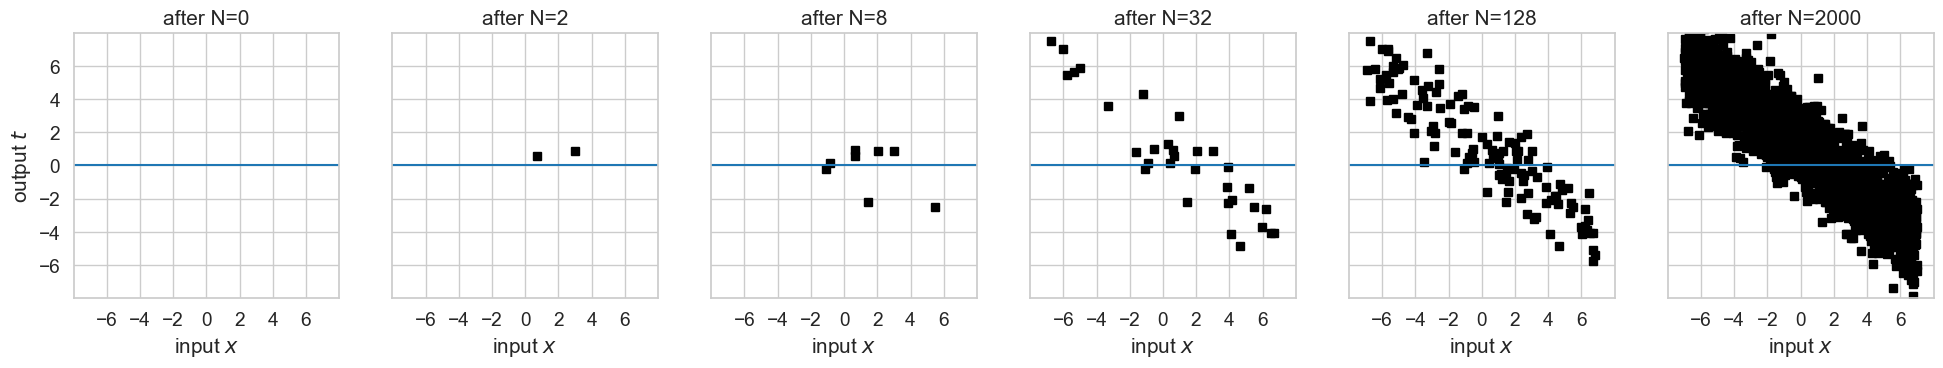

In [ ]:
# Define the number of observations to look at to make a posterior
N_values = [0, 2, 8, 32, 128, N]
C = len(N_values)

# Define the number of samples from the posterior to visualize
S = 10

# Create reproducible pseudorandom number generator
prng = np.random.RandomState(33)

# Create figure
fig_h, axgrid = plt.subplots(nrows=1, ncols=C, sharex=True, sharey=True, figsize=(C * 4, 4))

for col_id, Ncur in enumerate(N_values):
    w_ml_M = calc_ml_estimate_of_w_M(phi_NM[:Ncur], t_N[:Ncur])
        
    # Activate current subplot and get its handle
    ax_h = axgrid[col_id]
    
    # Show the observed data
    ax_h.plot(x_N1[:Ncur], t_N[:Ncur], linestyle='', marker='s', color='black')

    # Create a uniform grid of possible x values, to use in making predictions
    G = 101
    xgrid_G = np.linspace(-8, 8, G)[:,np.newaxis]
    t_ml_G = np.zeros(G) # TODOFIXME make prediction using w_ml_M
    
    # Show a plot of this sample on current axis
    ax_h.plot(xgrid_G, t_ml_G, '-');

    # Make plots pretty and standardized
    ax_h.set_aspect('equal', 'box');
    ax_h.set_xlim([-8, 8]); ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
    ax_h.set_ylim([-8, 8]); ax_h.set_yticks([-6, -4, -2, 0, 2, 4, 6]);
    ax_h.set_xlabel('input $x$')
    if col_id == 0:
        ax_h.set_ylabel('output $t$')
    ax_h.set_title('after N=%d' % Ncur)